# Workshop 1 - Introduction to Python and Jupyter notebooks for scientific data analysis

In [6]:
import skimage
import scipy.ndimage as sciND
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np
import pandas as pd

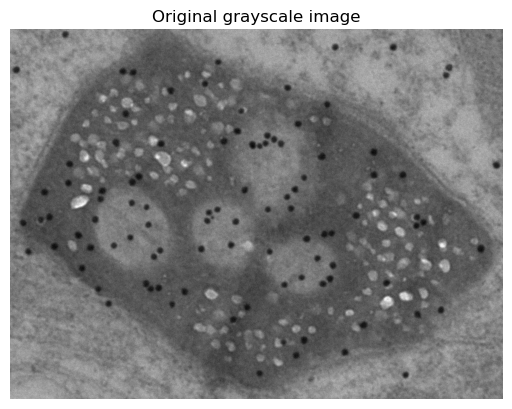

In [7]:
rawImgGray = skimage.io.imread('1543-1F-1_subset.png')
plt.imshow(rawImgGray, cmap='gray')
plt.title('Original grayscale image')
plt.axis('off')
plt.show()

In order to count and analyze the black dots, we first need to do some preprocessing.

These filters remove information we don't care about while enhancing information about the dots.

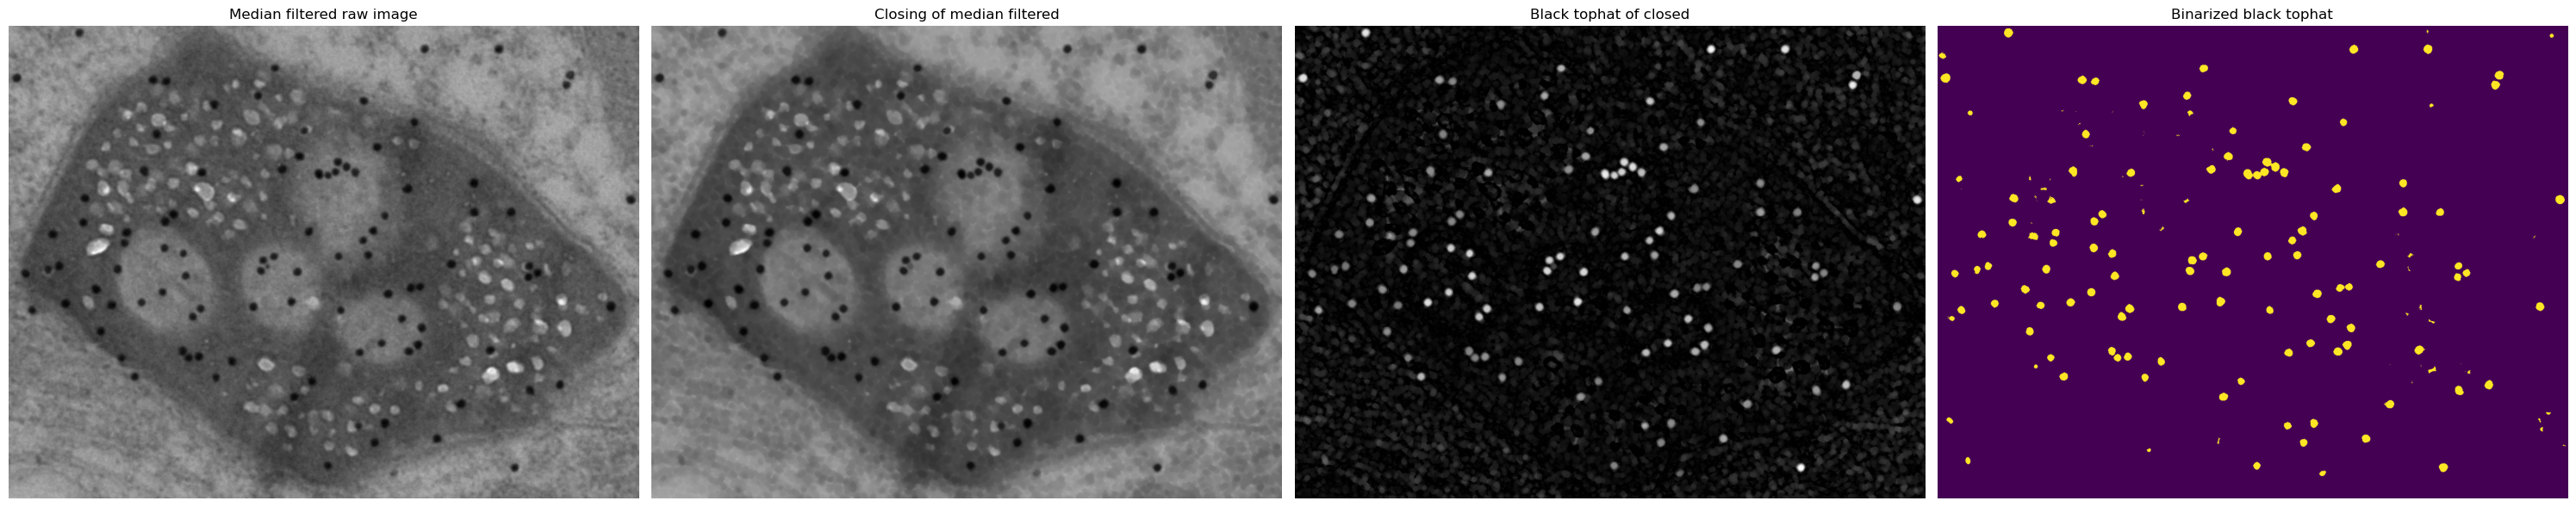

In [8]:
medF = skimage.filters.median(rawImgGray, footprint=skimage.morphology.disk(2)) # Median filter. A good simple noise removing filter. Removes fine detail which is useful for this analysis
closed = skimage.morphology.closing(medF, footprint=skimage.morphology.disk(4)) # Morphological closing removes more fine detail we don't need (makes later steps easier)
blackTopFilt = skimage.morphology.black_tophat(closed, footprint=skimage.morphology.disk(10)) # Black tophat filter enhances dark objects that are smaller than the footprint used
thresh = skimage.filters.threshold_otsu(blackTopFilt) # Used to calculate binary image. All pixel values above this threshold will be set to true, all others set to false
asBinary = blackTopFilt > thresh # Binary image. Only pixel values allowed are false or true (sometimes represented as 0 or 1)

f, axarr = plt.subplots(1, 4)

axarr[0].imshow(medF, cmap='gray')
axarr[0].axis('off')
axarr[0].title.set_text('Median filtered raw image')

axarr[1].imshow(closed, cmap='gray')
axarr[1].axis('off')
axarr[1].title.set_text('Closing of median filtered')

axarr[2].imshow(blackTopFilt, cmap='gray')
axarr[2].axis('off')
axarr[2].title.set_text('Black tophat of closed')

axarr[3].imshow(asBinary)
axarr[3].axis('off')
axarr[3].title.set_text('Binarized black tophat')
f.set_size_inches(30, 500)
f.tight_layout()

The initial binarization is good, but it needs more cleanup to remove small outliers.

Since the dots are around 13 to 19 pixels in diameter, they should have an area between 133 and 283 pixels. 

Therefore we can use area opening to remove any isolated objects smaller than 120 pixels to cleanup small outliers.

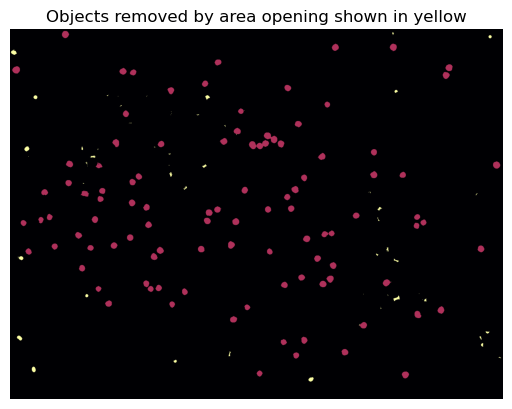

In [9]:
areaOpenedBW = skimage.morphology.area_opening(asBinary, area_threshold=120) # BW = Black/White (aka a binary image)
asLabels = skimage.util.img_as_ubyte(asBinary) # Convert false to a value of 0, and true to a value of 255 (8 bit image). Done so we can add another value for the removed objects to visualize them
asLabels[areaOpenedBW] = 120 # Sets pixel locations in asLabels that are true in areaOpenedBW to a value of 120. Now asLabels pixels have one of three values (0, 120, or 255)
plt.imshow(asLabels, cmap='inferno')
plt.title('Objects removed by area opening shown in yellow')
plt.axis('off')
plt.show()

A lot closer. However, a few dots are still touching (and would be treated as the same dot in a count).

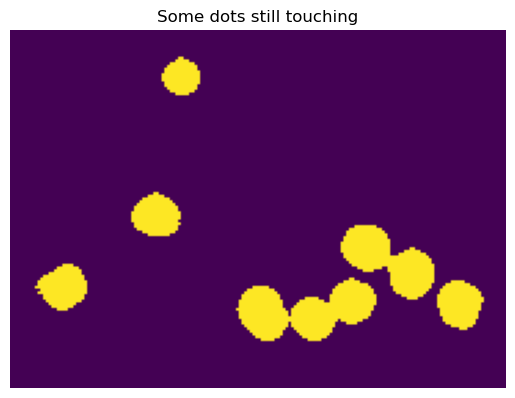

In [10]:
plt.imshow(areaOpenedBW[190:320, 520:700])
plt.title('Some dots still touching')
plt.axis('off')
plt.show()

We can use a distance transform combined with watershed to seperate these dots

Region property filtering removed 2 dots


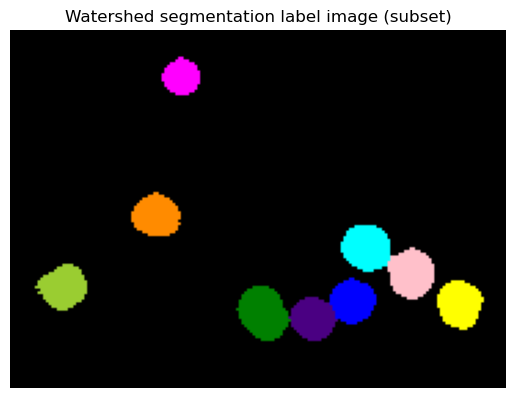

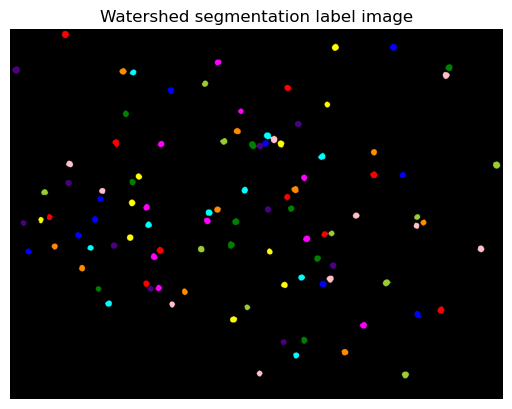

In [11]:
def seperateOverlappingWatershedBW(binary2D: np.ndarray):
    # The code under this "def" is a function. It lets you create units of code that are easy to reuse and modify.
    # It also makes maintaining code much easier.
    # This function is based on the example watershed code from skimage.segmentation.watershed
    # It takes a single input, binary2D, and returns a single output, watershedLabels
    # The : np.ndarray in the input tells python that the input must be a numpy array (np.ndarray)
    if binary2D.ndim != 2:
        # ^This is a test to make sure the input is always two dimensional (a 2D image)
        raise Exception("ERROR::Function input is not 2D") # If that test is true, then everything inside the "if" runs
        # ^this will cause an error and stop your code
        # Try changing the 2 to a 3, then run this cell. Look at the output below this cell.
    _, uniqueCount = np.unique(binary2D, return_counts=True) # Find the number of unique pixel values in the input image
    if uniqueCount.shape[0] == 1:
        raise Exception("ERROR::Only one unique pixel value in input function. Empty image?")
    distance = sciND.distance_transform_bf(binary2D)
    max_coords = skimage.feature.peak_local_max(distance, labels=binary2D,
                                footprint=skimage.morphology.disk(4), min_distance=5) # Using min_distance parameter helps prevent dots that are split into multiple segmentations
    local_maxima = np.zeros_like(binary2D, dtype=bool)
    local_maxima[tuple(max_coords.T)] = True
    markers = sciND.label(local_maxima)[0]
    watershedLabels = skimage.segmentation.watershed(-distance, markers, mask=binary2D)
    # Final step is to cleanup the labels by removing small objects and objects that are not "round"
    removedCount = 0
    for region in skimage.measure.regionprops(watershedLabels): # Loop over each seperate object found
        roundnessRatio = (4 * np.pi * region.area) / (region.perimeter**2) # Shai Bagon (stackoverflow 7-2014)
        if (region.area <= 100) or (roundnessRatio < 0.8):
            watershedLabels[watershedLabels == region.label] = 0 # set that label to background (label = 0)
            removedCount = removedCount + 1
    return watershedLabels, removedCount

watershedLabels, removedCount = seperateOverlappingWatershedBW(areaOpenedBW)
print('Region property filtering removed ' + str(removedCount) + ' dots')
asRGB = skimage.color.label2rgb(watershedLabels)
plt.imshow(asRGB[190:320, 520:700])
plt.title('Watershed segmentation label image (subset)')
plt.axis('off')
plt.show()

plt.imshow(asRGB)
plt.title('Watershed segmentation label image')
plt.axis('off')
plt.show()

Now that we have the final label image with each dot labeled, we can measure and count each one.

For this example we will only export the area and perimeter of each dot, but there are many more properties you could pick (see available properties for skimage.measure.regionprops)

In [7]:
dotProperties = skimage.measure.regionprops_table(watershedLabels, properties=['label', 'area', 'perimeter'])
asDataframe = pd.DataFrame(dotProperties) # Pandas dataframe
asDataframe.to_excel('dotInfo.xlsx') # there is also a .to_csv option etc.

Added some markup to this branch

We can also generate some plots and export those directly. Here we generate a histogram of dot area and export it as an image

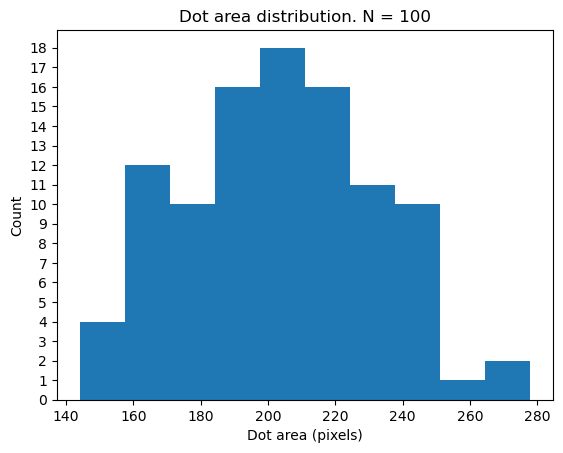

In [17]:
dotPropertiesList = skimage.measure.regionprops(watershedLabels) # Normal regionprops returns a list rather than a table
dotAreas = [regions.area for regions in dotPropertiesList] # Grab just the area values. This is a for loop to get each one, but done in a single line
nDots = np.shape(dotAreas)[0]
plt.hist(dotAreas)
plt.xlabel('Dot area (pixels)')
plt.ylabel('Count')
plt.title('Dot area distribution. N = ' + str(nDots))
plt.gca().yaxis.set_major_locator(mticker.MultipleLocator(1)) # This forces integer only values for the Y-axis (since it is count)
plt.savefig('histAsFig.png', dpi=300) # dpi = dots per inch. ~300 is a good default for posters (depends on print area)

With that, we have now counted and analyzed all the dots in the image.

If you want further practice, here are some things to try:
- Create a looped version of this method (take a folder of images, do this analayis on each one, then export a single excel with all the info).
- Export the label image as a tif so it can be used with other analysis.

As a final note, this dot counting method works ok but it is vunerable to improper segmentation. It is useful as a teaching tool, but for a more ideal method lookup the fast radial symmetry transform. Since the dots are very radially symmetric, this transform makes it easy to exclude everything except for these dots.